In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import norm
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc
rc('animation', html='jshtml')
## Sætter grænseværdien for animationsstørrelsen op##
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [5]:
a = np.array([1,2])
np.sqrt(1**2+2**2)**3,norm(a)**3


(11.18033988749895, 11.18033988749895)

In [88]:
### INITIAL CONDITIONS ###
m1, m2, m3 = 1, 1, 1
Grav_const = 1


### Coefficient tables ####
# https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta%E2%80%93Fehlberg_method #

A = np.array([0,2/9,1/3,3/4,1,5/6])
B = np.array([[],[2/9],[1/12,1/4],[69/128,-243/128,135/64],[-17/12,27/4,-27/5,16/15],[65/432,-5/16,13/16,4/27,5/144]])
C = np.array([1/9,0,2/20,16/45,1/12])
CH = np.array([47/450,0,12/25,32/225,1/30,6/25])
CT = np.array([-1/150,0,3/100,-16/75,-1/20,6/25])

In [89]:
### FUNCTION(S) ###

def force_pair1(r_1,r_2,m2,Grav_const):
    numerator   = r_1-r_2 
    denominator = norm(r_1-r_2)**3
    fraction    = numerator/denominator
    return Grav_const*m2*fraction

### dv/dt functions ###
def dvdt1(r_1,r_2,r_3,G,m_1,m_2,m_3):
    first = force_pair1(r_1,r_2,m_2,G)
    second = force_pair1(r_1,r_3,m_3,G)
    return -first-second

def dvdt2(r_1,r_2,r_3,G,m_1,m_2,m_3):
    first = force_pair1(r_2,r_3,m_3,G)
    second = force_pair1(r_2,r_1,m_1,G)
    return -first-second

def dvdt3(r_1,r_2,r_3,G,m_1,m_2,m_3):
    first = force_pair1(r_3,r_1,m_1,G)
    second = force_pair1(r_3,r_2,m_2,G)
    return -first-second

### dr/dt functions ###
def drdt1(v_1):
    return v_1

def drdt2(v_2):
    return v_2

def drdt3(v_3):
    return v_3

####### RK-constant functions #######

### K1 ###
def r_k1(n,h,r_1,r_2,r_3):
    if n == 1:
        return h*dvdt1(r_1,r_2,r_3,Grav_const,m1,m2,m3)
    if n == 2:
        return h*dvdt2(r_1,r_2,r_3,Grav_const,m1,m2,m3)
    if n == 3:
        return h*dvdt3(r_1,r_2,r_3,Grav_const,m1,m2,m3)

def v_k1(n,h,v_1,v_2,v_3):
    if n == 1:
        return h*drdt1(v_1)
    if n == 2:
        return h*drdt2(v_2)
    if n == 3:
        return h*drdt1(v_3)

### K2 ###
def r_k2(n,v1_k1,v2_k1,v3_k1,h,r_1,r_2,r_3):
    c1 = B[1][0]*v1_k1
    c2 = B[1][0]*v2_k1
    c3 = B[1][0]*v3_k1
    if n ==1:
        return h*dvdt1(r_1+c1,r_2+c2,r_3+c3,Grav_const,m1,m2,m3)
    if n ==2:
        return h*dvdt2(r_1+c1,r_2+c2,r_3+c3,Grav_const,m1,m2,m3)
    if n ==3:
        return h*dvdt3(r_1+c1,r_2+c2,r_3+c3,Grav_const,m1,m2,m3)

def v_k2(n,r1_k1,r2_k1,r3_k1,h,v_1,v_2,v_3):
    if n == 1:
        c =  B[1][0]*r1_k1
        return h*drdt1(v_1+c)
    if n == 2:
        c =  B[1][0]*r2_k1
        return h*drdt2(v_2+c)
    if n == 3:
        c =  B[1][0]*r3_k1
        return h*drdt3(v_3+c)

### K3 ###
def r_k3(n,v1_k1,v2_k1,v3_k1,v1_k2,v2_k2,v3_k2,h,r_1,r_2,r_3):
    c1 = B[2][0]*v1_k1+B[2][1]*v1_k2
    c2 = B[2][0]*v2_k1+B[2][1]*v2_k2
    c3 = B[2][0]*v3_k1+B[2][1]*v3_k2
    if n ==1:
        return h*dvdt1(r_1+c1,r_2+c2,r_3+c3,Grav_const,m1,m2,m3)
    if n ==2:
        return h*dvdt2(r_1+c1,r_2+c2,r_3+c3,Grav_const,m1,m2,m3)
    if n ==3:
        return h*dvdt3(r_1+c1,r_2+c2,r_3+c3,Grav_const,m1,m2,m3)

def v_k3(n,r1_k1,r2_k1,r3_k1,r1_k2,r2_k2,r3_k2,h,v_1,v_2,v_3):
    if n == 1:
        c =   B[2][0]*r1_k1+B[2][1]*r1_k2
        return h*drdt1(v_1+c)
    if n == 2:
        c =   B[2][0]*r2_k1+B[2][1]*r2_k2
        return h*drdt2(v_2+c)
    if n == 3:
        c =   B[2][0]*r3_k1+B[2][1]*r3_k2
        return h*drdt3(v_3+c)

### K4 ###
def r_k4(n,v1_k1,v2_k1,v3_k1,v1_k2,v2_k2,v3_k2,v1_k3,v2_k3,v3_k3,h,r_1,r_2,r_3):
    c1 = B[3][0]*v1_k1+B[3][1]*v1_k2+B[3][2]*v1_k3
    c2 = B[3][0]*v2_k1+B[3][1]*v2_k2+B[3][2]*v2_k3
    c3 = B[3][0]*v3_k1+B[3][1]*v3_k2+B[3][2]*v3_k3
    if n ==1:
        return h*dvdt1(r_1+c1,r_2+c2,r_3+c3,Grav_const,m1,m2,m3)
    if n ==2:
        return h*dvdt2(r_1+c1,r_2+c2,r_3+c3,Grav_const,m1,m2,m3)
    if n ==3:
        return h*dvdt3(r_1+c1,r_2+c2,r_3+c3,Grav_const,m1,m2,m3)

def v_k4(n,r1_k1,r2_k1,r3_k1,r1_k2,r2_k2,r3_k2,r1_k3,r2_k3,r3_k3,h,v_1,v_2,v_3):
    if n == 1:
        c =   B[3][0]*r1_k1+B[3][1]*r1_k2+B[3][2]*r1_k3
        return h*drdt1(v_1+c)
    if n == 2:
        c =   B[3][0]*r2_k1+B[3][1]*r2_k2+B[3][2]*r2_k3
        return h*drdt2(v_2+c)
    if n == 3:
        c =   B[3][0]*r3_k1+B[3][1]*r3_k2+B[3][2]*r3_k3
        return h*drdt3(v_3+c)

### K5 ###
def r_k5(n,v1_k1,v2_k1,v3_k1,v1_k2,v2_k2,v3_k2,v1_k3,v2_k3,v3_k3,v1_k4,v2_k4,v3_k4,h,r_1,r_2,r_3):
    c1 = B[4][0]*v1_k1+B[4][1]*v1_k2+B[4][2]*v1_k3+B[4][3]*v1_k4
    c2 = B[4][0]*v2_k1+B[4][1]*v2_k2+B[4][2]*v2_k3+B[4][3]*v2_k4
    c3 = B[4][0]*v3_k1+B[4][1]*v3_k2+B[4][2]*v3_k3+B[4][3]*v3_k4
    if n ==1:
        return h*dvdt1(r_1+c1,r_2+c2,r_3+c3,Grav_const,m1,m2,m3)
    if n ==2:
        return h*dvdt2(r_1+c1,r_2+c2,r_3+c3,Grav_const,m1,m2,m3)
    if n ==3:
        return h*dvdt3(r_1+c1,r_2+c2,r_3+c3,Grav_const,m1,m2,m3)

def v_k5(n,r1_k1,r2_k1,r3_k1,r1_k2,r2_k2,r3_k2,r1_k3,r2_k3,r3_k3,r1_k4,r2_k4,r3_k4,h,v_1,v_2,v_3):
    if n == 1:
        c =   B[4][0]*r1_k1+B[4][1]*r1_k2+B[4][2]*r1_k3+B[4][3]*r1_k4
        return h*drdt1(v_1+c)
    if n == 2:
        c =   B[4][0]*r2_k1+B[4][1]*r2_k2+B[4][2]*r2_k3+B[4][3]*r2_k4
        return h*drdt2(v_2+c)
    if n == 3:
        c =   B[4][0]*r3_k1+B[4][1]*r3_k2+B[4][2]*r3_k3+B[4][3]*r3_k4
        return h*drdt3(v_3+c)

### K6 ###
def r_k6(n,v1_k1,v2_k1,v3_k1,v1_k2,v2_k2,v3_k2,v1_k3,v2_k3,v3_k3,v1_k4,v2_k4,v3_k4,v1_k5,v2_k5,v3_k5,h,r_1,r_2,r_3):
    c1 = B[5][0]*v1_k1+B[5][1]*v1_k2+B[5][2]*v1_k3+B[5][3]*v1_k4+B[5][4]*v1_k5
    c2 = B[4][0]*v2_k1+B[4][1]*v2_k2+B[4][2]*v2_k3+B[4][3]*v2_k4+B[5][4]*v2_k5
    c3 = B[4][0]*v3_k1+B[4][1]*v3_k2+B[4][2]*v3_k3+B[4][3]*v3_k4+B[5][4]*v3_k5
    if n ==1:
        return h*dvdt1(r_1+c1,r_2+c2,r_3+c3,Grav_const,m1,m2,m3)
    if n ==2:
        return h*dvdt2(r_1+c1,r_2+c2,r_3+c3,Grav_const,m1,m2,m3)
    if n ==3:
        return h*dvdt3(r_1+c1,r_2+c2,r_3+c3,Grav_const,m1,m2,m3)

def v_k6(n,r1_k1,r2_k1,r3_k1,r1_k2,r2_k2,r3_k2,r1_k3,r2_k3,r3_k3,r1_k4,r2_k4,r3_k4,r1_k5,r2_k5,r3_k5,h,v_1,v_2,v_3):
    if n == 1:
        c =   B[5][0]*r1_k1+B[5][1]*r1_k2+B[5][2]*r1_k3+B[5][3]*r1_k4+B[5][4]*r1_k5
        return h*drdt1(v_1+c)
    if n == 2:
        c =   B[5][0]*r2_k1+B[5][1]*r2_k2+B[5][2]*r2_k3+B[5][3]*r2_k4+B[5][4]*r1_k5
        return h*drdt2(v_2+c)
    if n == 3:
        c =   B[5][0]*r3_k1+B[5][1]*r3_k2+B[5][2]*r3_k3+B[5][3]*r3_k4+B[5][4]*r1_k5
        return h*drdt3(v_3+c)

######### Step i+1 function ##########

def ri_1(r,vk1,vk2,vk3,vk4,vk5,vk6):
    c = CH[0]*vk1+CH[1]*vk2+CH[2]*vk3+CH[3]*vk4+CH[4]*vk5+CH[5]*vk6
    return r + c

def vi_1(v,vk1,vk2,vk3,vk4,vk5,vk6):
    c = CH[0]*vk1+CH[1]*vk2+CH[2]*vk3+CH[3]*vk4+CH[4]*vk5+CH[5]*vk6
    return v + c


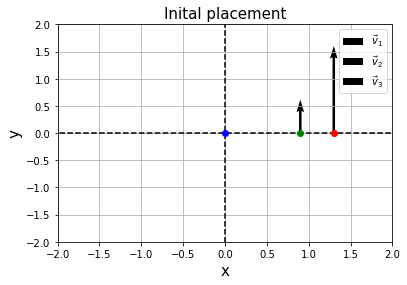

In [91]:
### Plotting initial placement ### 

r1, r2, r3 = np.array([0,0,0]), np.array([0.9,0,0]), np.array([1.3,0,0])
v1, v2, v3 = np.array([0,0,0]), np.array([0,0.5,0]), np.array([0,1.3,0])

plt.plot(r1[0],r1[1],'o',color='b'), plt.plot(r2[0],r2[1],'o',color='g'), plt.plot(r3[0],r3[1],'o',color='r')
plt.grid(), plt.hlines(0,-100,100,ls='--'),plt.vlines(0,-100,100,ls='--')
plt.quiver(r1[0],r1[1],v1[0],v1[1], scale=5, label = r'$\vec{v}_1$')
plt.quiver(r2[0],r2[1],v2[0],v2[1], scale=5, label = r'$\vec{v}_2$')
plt.quiver(r3[0],r3[1],v3[0],v3[1], scale=5, label = r'$\vec{v}_3$')
plt.xlim(-2,2), plt.ylim(-2,2), plt.xlabel('x',size=15), plt.ylabel('y',size=15)
plt.title('Inital placement', size =15), plt.legend()
plt.show()

In [92]:
x_1, y_1, z_1 = [], [], []
x_2, y_2, z_2 = [], [], []
x_3, y_3, z_3 = [], [], []

x_1.append(r1[0]),y_1.append(r1[1]),z_1.append(r1[2])
x_2.append(r2[0]),y_2.append(r2[1]),z_2.append(r2[2])
x_3.append(r3[0]),y_3.append(r3[1]),z_3.append(r3[2])

vx_1, vy_1, vz_1 = [], [], []
vx_2, vy_2, vz_2 = [], [], []
vx_3, vy_3, vz_3 = [], [], []

vx_1.append(v1[0]),vy_1.append(v1[1]),vz_1.append(v1[2])
vx_2.append(v2[0]),vy_2.append(v2[1]),vz_2.append(v2[2])
vx_3.append(v3[0]),vy_3.append(v3[1]),vz_3.append(v3[2])

(None, None, None)

In [93]:
def calculation(h1,r_1,r_2,r_3,v_1,v_2,v_3):
    #### K1 Calculations ####
    r1_k1, r2_k1, r3_k1 = r_k1(1,h1,r_1,r_2,r_3), r_k1(2,h1,r_1,r_2,r_3), r_k1(3,h1,r_1,r_2,r_3)
    v1_k1, v2_k1, v3_k1 = v_k1(1,h1,v_1,v_2,v_3), v_k1(2,h1,v_1,v_2,v_3), v_k1(3,h1,v_1,v_2,v_3)

    #### K2 Calculations ####
    r1_k2, r2_k2, r3_k2 = r_k2(1,v1_k1, v2_k1, v3_k1,h1,r_1,r_2,r_3), r_k2(2,v1_k1, v2_k1, v3_k1,h1,r_1,r_2,r_3), r_k2(3,v1_k1, v2_k1, v3_k1,h1,r_1,r_2,r_3)
    v1_k2, v2_k2, v3_k2 = v_k2(1,r1_k1, r2_k1, r3_k1,h1,v_1,v_2,v_3), v_k2(2,r1_k1, r2_k1, r3_k1,h1,v_1,v_2,v_3), v_k2(3,r1_k1, r2_k1, r3_k1,h1,v_1,v_2,v_3)

    #### K3 Calculations ####
    r1_k3, r2_k3, r3_k3 = r_k3(1,v1_k1, v2_k1, v3_k1,v1_k2, v2_k2, v3_k2,h1,r_1,r_2,r_3), r_k3(2,v1_k1, v2_k1, v3_k1,v1_k2, v2_k2, v3_k2,h1,r_1,r_2,r_3), r_k3(3,v1_k1, v2_k1, v3_k1,v1_k2, v2_k2, v3_k2,h1,r_1,r_2,r_3)
    v1_k3, v2_k3, v3_k3 = v_k3(1,r1_k1, r2_k1, r3_k1,r1_k2, r2_k2, r3_k2,h1,v_1,v_2,v_3), v_k3(2,r1_k1, r2_k1, r3_k1,r1_k2, r2_k2, r3_k2,h1,v_1,v_2,v_3), v_k3(3,r1_k1, r2_k1, r3_k1,r1_k2, r2_k2, r3_k2,h1,v_1,v_2,v_3)

    #### K4 Calculations ####
    r1_k4, r2_k4 = r_k4(1,v1_k1, v2_k1, v3_k1,v1_k2, v2_k2, v3_k3, v1_k3, v2_k3, v3_k3,h1,r_1,r_2,r_3), r_k4(2,v1_k1, v2_k1, v3_k1,v1_k2, v2_k2, v3_k3, v1_k3, v2_k3, v3_k3,h1,r_1,r_2,r_3)
    r3_k4, v1_k4 = r_k4(3,v1_k1, v2_k1, v3_k1,v1_k2, v2_k2, v3_k3, v1_k3, v2_k3, v3_k3,h1,r_1,r_2,r_3), v_k4(1,r1_k1, r2_k1, r3_k1,r1_k2, r2_k2, r3_k2, r1_k3, r2_k3, r3_k3,h1,v_1,v_2,v_3)
    v2_k4, v3_k4 = v_k4(2,r1_k1, r2_k1, r3_k1,r1_k2, r2_k2, r3_k2, r1_k3, r2_k3, r3_k3,h1,v_1,v_2,v_3), v_k4(3,r1_k1, r2_k1, r3_k1,r1_k2, r2_k2, r3_k2, r1_k3, r2_k3, r3_k3,h1,v_1,v_2,v_3)

    #### K5 Calculations ####
    r1_k5, r2_k5 = r_k5(1,v1_k1, v2_k1, v3_k1,v1_k2, v2_k2, v3_k3, v1_k3, v2_k3, v3_k3, v1_k4, v2_k4, v3_k4,h1,r_1,r_2,r_3), r_k5(2,v1_k1, v2_k1, v3_k1,v1_k2, v2_k2, v3_k3, v1_k3, v2_k3, v3_k3, v1_k4, v2_k4, v3_k4,h1,r_1,r_2,r_3)
    r3_k5, v1_k5 = r_k5(3,v1_k1, v2_k1, v3_k1,v1_k2, v2_k2, v3_k3, v1_k3, v2_k3, v3_k3, v1_k4, v2_k4, v3_k4,h1,r_1,r_2,r_3), v_k5(1,r1_k1, r2_k1, r3_k1,r1_k2, r2_k2, r3_k2, r1_k3, r2_k3, r3_k3, r1_k4, r2_k4, r3_k4,h1,v_1,v_2,v_3)
    v2_k5, v3_k5 = v_k5(2,r1_k1, r2_k1, r3_k1,r1_k2, r2_k2, r3_k2, r1_k3, r2_k3, r3_k3, r1_k4, r2_k4, r3_k4,h1,v_1,v_2,v_3), v_k5(3,r1_k1, r2_k1, r3_k1,r1_k2, r2_k2, r3_k2, r1_k3, r2_k3, r3_k3, r1_k4, r2_k4, r3_k4,h1,v_1,v_2,v_3)
    
    #### K6 Calculations ####
    r1_k6 = r_k6(1,v1_k1, v2_k1, v3_k1,v1_k2, v2_k2, v3_k3, v1_k3, v2_k3, v3_k3, v1_k4, v2_k4, v3_k4, v1_k5, v2_k5, v3_k5,h1,r_1,r_2,r_3)
    r2_k6 = r_k6(2,v1_k1, v2_k1, v3_k1,v1_k2, v2_k2, v3_k3, v1_k3, v2_k3, v3_k3, v1_k4, v2_k4, v3_k4, v1_k5, v2_k5, v3_k5,h1,r_1,r_2,r_3)
    r3_k6 = r_k6(3,v1_k1, v2_k1, v3_k1,v1_k2, v2_k2, v3_k3, v1_k3, v2_k3, v3_k3, v1_k4, v2_k4, v3_k4, v1_k5, v2_k5, v3_k5,h1,r_1,r_2,r_3)
    v1_k6 = v_k6(1,r1_k1, r2_k1, r3_k1,r1_k2, r2_k2, r3_k2, r1_k3, r2_k3, r3_k3, r1_k4, r2_k4, r3_k4, r1_k5, r2_k5, r3_k5,h1,v_1,v_2,v_3)
    v2_k6 = v_k6(2,r1_k1, r2_k1, r3_k1,r1_k2, r2_k2, r3_k2, r1_k3, r2_k3, r3_k3, r1_k4, r2_k4, r3_k4, r1_k5, r2_k5, r3_k5,h1,v_1,v_2,v_3)
    v3_k6 = v_k6(3,r1_k1, r2_k1, r3_k1,r1_k2, r2_k2, r3_k2, r1_k3, r2_k3, r3_k3, r1_k4, r2_k4, r3_k4, r1_k5, r2_k5, r3_k5,h1,v_1,v_2,v_3)
       
    #### r:i+1 and v_i+1 calculations ####
    r1_i1, r2_i1, r3_i1 = ri_1(r_1,v1_k1,v1_k2,v1_k3,v1_k4,v1_k5,v1_k6), ri_1(r_2,v2_k1,v2_k2,v2_k3,v2_k4,v2_k5,v2_k6), ri_1(r_3,v3_k1,v3_k2,v3_k3,v3_k4,v3_k5,v3_k6) 
    v1_i1, v2_i1, v3_i1 = vi_1(v_1,r1_k1,r1_k2,r1_k3,r1_k4,r1_k5,r1_k6), vi_1(v_2,r2_k1,r2_k2,r2_k3,r2_k4,r2_k5,r2_k6), vi_1(v_3,r3_k1,r3_k2,r3_k3,r3_k4,r3_k5,r3_k6) 
    
    sols = [r1_i1, r2_i1, r3_i1, v1_i1, v2_i1, v3_i1]
    
    #### Calculating error estimate ####   
    const_s = np.array([[r1_k1,r1_k2,r1_k3,r1_k4,r1_k5,r1_k6],[r2_k1,r2_k2,r2_k3,r2_k4,r2_k5,r2_k6],[r3_k1,r3_k2,r3_k3,r3_k4,r3_k5,r3_k6],
                        [v1_k1,v1_k2,v1_k3,v1_k4,v1_k5,v1_k6],[v2_k1,v2_k2,v2_k3,v2_k4,v2_k5,v2_k6],[v3_k1,v3_k2,v3_k3,v3_k4,v3_k5,v3_k6]])    
    TE_s = []
    for i in range(len(const_s)):
        TE_temp = norm(const_s[i][0]*CT[0]+const_s[i][1]*CT[1]+const_s[i][2]*CT[2]+const_s[i][3]*CT[3]+const_s[i][4]*CT[4]+const_s[i][5]*CT[5])
        TE_s.append(TE_temp)
    max_error = np.max(np.array(TE_s))
    
    return sols, max_error
    

In [116]:
#################################################################### NUMERISK RK4 MED ADAPTIV STEPSIZE LØSNING ############################################################################
### INITIAL CONDITIONS ###
m1, m2, m3 = 1,1,1
Grav_const = 1
r1, r2, r3 = np.array([-1,0,0]), np.array([0.9,0,0]), np.array([1.3,0,0])
v1, v2, v3 = np.array([0,-0.1,0]), np.array([0,0.5,0]), np.array([0.4,1.3,0])


#### INITIAL CONFIGURATIONS ####
Time_interval = [0,10]
Step_size = 1e-3
threshold = 1e-7

x_1, y_1, z_1 = [], [], []
x_2, y_2, z_2 = [], [], []
x_3, y_3, z_3 = [], [], []

x_1.append(r1[0]),y_1.append(r1[1]),z_1.append(r1[2])
x_2.append(r2[0]),y_2.append(r2[1]),z_2.append(r2[2])
x_3.append(r3[0]),y_3.append(r3[1]),z_3.append(r3[2])

vx_1, vy_1, vz_1 = [], [], []
vx_2, vy_2, vz_2 = [], [], []
vx_3, vy_3, vz_3 = [], [], []

vx_1.append(v1[0]),vy_1.append(v1[1]),vz_1.append(v1[2])
vx_2.append(v2[0]),vy_2.append(v2[1]),vz_2.append(v2[2])
vx_3.append(v3[0]),vy_3.append(v3[1]),vz_3.append(v3[2])

percentage_counter = 0
time_elapsed = 0
while time_elapsed < Time_interval[-1]:
    
    #### Defining v_i and r_i for all three bodies ###
    r1, r2, r3 = np.array([x_1[-1],y_1[-1],z_1[-1]]), np.array([x_2[-1],y_2[-1],z_2[-1]]), np.array([x_3[-1],y_3[-1],z_3[-1]])
    v1, v2, v3 = np.array([vx_1[-1],vy_1[-1],vz_1[-1]]), np.array([vx_2[-1],vy_2[-1],vz_2[-1]]), np.array([vx_3[-1],vy_3[-1],vz_3[-1]]) 

    sol, max_err = calculation(Step_size,r1,r2,r3,v1,v2,v3)

    while(max_err>=threshold):
        #### Calculating new stepsize -> smaller steps ####
        Step_size = 0.9*Step_size*(threshold/max_err)**(1/5)
        
        #### Calculating with new stepsize ####
        sol, max_err = calculation(Step_size,r1,r2,r3,v1,v2,v3)

    r1_i1, r2_i1, r3_i1, v1_i1, v2_i1, v3_i1 = sol[0], sol[1], sol[2], sol[3], sol[4], sol[5]

    #### Appending values ####
    x_1.append(r1_i1[0]),y_1.append(r1_i1[1]),z_1.append(r1_i1[2])
    x_2.append(r2_i1[0]),y_2.append(r2_i1[1]),z_2.append(r2_i1[2])
    x_3.append(r3_i1[0]),y_3.append(r3_i1[1]),z_3.append(r3_i1[2])

    vx_1.append(v1_i1[0]),vy_1.append(v1_i1[1]),vz_1.append(v1_i1[2])
    vx_2.append(v2_i1[0]),vy_2.append(v2_i1[1]),vz_2.append(v2_i1[2])
    vx_3.append(v3_i1[0]),vy_3.append(v3_i1[1]),vz_3.append(v3_i1[2])
    
    #### Calculating new stepsize -> Bigger steps ####
    Step_size = 0.9*Step_size*(threshold/max_err)**(1/5)
    
    t1 = round(time_elapsed/Time_interval[-1]*100)
    
    time_elapsed += Step_size
    
    t2 = round(time_elapsed/Time_interval[-1]*100)
    
    if t2 > t1:
        percentage_counter += 1
        if percentage_counter == 5:
            print(f'{t2} % done')
            percentage_counter = 0

            

5.0 % done
10.0 % done
15.0 % done
20.0 % done
25.0 % done
30.0 % done
35.0 % done
40.0 % done
45.0 % done
50.0 % done
55.0 % done
60.0 % done
65.0 % done
70.0 % done
75.0 % done
80.0 % done
85.0 % done
90.0 % done
95.0 % done
100.0 % done


In [118]:
            
#################################################################### NUMERISK SOLVE-IVP LØSNING ############################################################################


### SIMULATION CONFIGURATIONS ###

tinit = 0
tfinal = Time_interval[-1]
trange = [tinit,tfinal]
ts = np.linspace(tinit, tfinal, 100000)

### INITIAL CONDITIONS ###
G = Grav_const
r1, r2, r3 = np.array([-1,0,0]), np.array([0.9,0,0]), np.array([1.3,0,0])
v1, v2, v3 = np.array([0,-0.1,0]), np.array([0,0.5,0]), np.array([0.4,1.3,0])
y_init = np.concatenate([r1,v1,r2,v2,r3,v3])


def dydt(t,y):
    r1     = y[0:3]
    r1_dot = y[3:6]
    r2     = y[6:9]
    r2_dot = y[9:12]
    r3     = y[12:15]
    r3_dot = y[15:18]
    
    d_r1_dt = r1_dot
    d_r2_dt = r2_dot
    d_r3_dt = r3_dot
    
    d_r1_dot_dt = -G*m2*((r1-r2)/(norm(r1-r2)**3))-G*m3*((r1-r3)/(norm(r1-r3)**3))
    d_r2_dot_dt = -G*m3*((r2-r3)/(norm(r2-r3)**3))-G*m1*((r2-r1)/(norm(r2-r1)**3))
    d_r3_dot_dt = -G*m1*((r3-r1)/(norm(r3-r1)**3))-G*m2*((r3-r2)/(norm(r3-r2)**3))
    
    return np.concatenate([d_r1_dt,d_r1_dot_dt,d_r2_dt,d_r2_dot_dt,d_r3_dt,d_r3_dot_dt])

mysol = solve_ivp(dydt, trange, y_init, t_eval = ts,rtol=3e-14)

time_vals = mysol.t

r1_x, r1_y = mysol.y[0], mysol.y[1]
v1_x, v1_y = mysol.y[3], mysol.y[4]

r2_x, r2_y = mysol.y[6], mysol.y[7]
v2_x, v2_y = mysol.y[9], mysol.y[10]

r3_x, r3_y = mysol.y[12], mysol.y[13]
v3_x, v3_y = mysol.y[15], mysol.y[16]

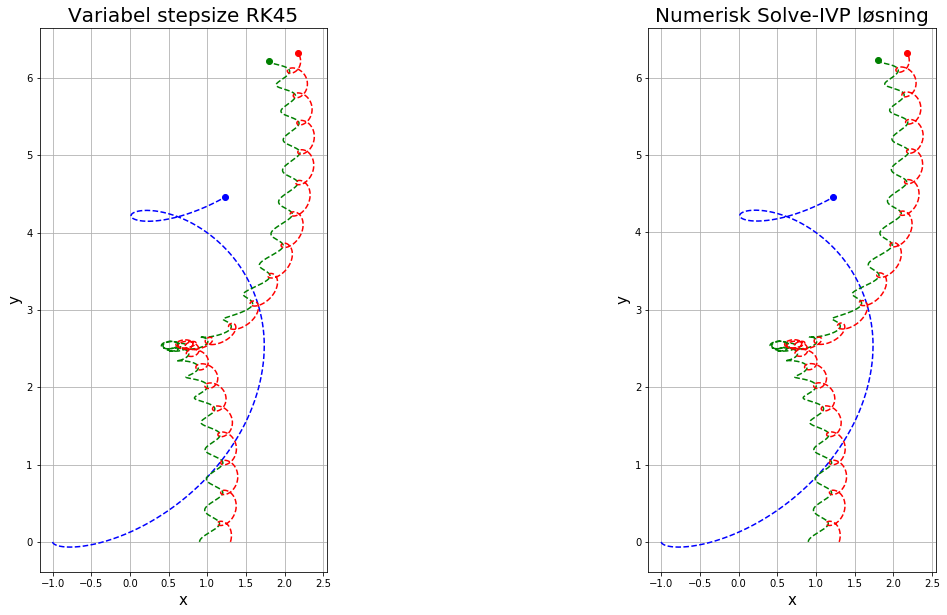

In [120]:
fig, ax = plt.subplots(1,2,figsize=(20,10))

ax[0].plot(x_1,y_1,ls='--',color='b'), ax[0].plot(x_2,y_2,ls='--',color='g'),ax[0].plot(x_3,y_3,ls='--',color='r'), ax[0].grid(), ax[0].set_title('Variabel stepsize RK45',size=20)
ax[0].plot(x_1[-1],y_1[-1],'o',color='b'), ax[0].plot(x_2[-1],y_2[-1],'o',color='g'), ax[0].plot(x_3[-1],y_3[-1],'o',color='r')
ax[0].set_aspect('equal'), ax[0].set_xlabel('x',size=15),  ax[0].set_ylabel('y',size=15)

ax[1].plot(r1_x,r1_y,ls='--',color='b'), ax[1].plot(r2_x,r2_y,ls='--',color='g'), ax[1].plot(r3_x,r3_y,ls='--',color='r'), ax[1].grid(), ax[1].set_title('Numerisk Solve-IVP løsning',size=20)
ax[1].set_aspect('equal'), ax[1].set_xlabel('x',size=15),  ax[1].set_ylabel('y',size=15)
ax[1].plot(r1_x[-1],r1_y[-1],'o',color='b'), ax[1].plot(r2_x[-1],r2_y[-1],'o',color='g'), ax[1].plot(r3_x[-1],r3_y[-1],'o',color='r')

plt.show()